# COVID19 Chest X-Ray Project

This dataset was taken from kaggle:
https://www.kaggle.com/toxite/covid-19-cxr-ny-sbu

Original data source:
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=89096912

The goal of this project will be to determine if X-ray images can be used with other patient data to predict whether or not a patient will survive COVID19 infection. First, we will separate images into two classes based upon the data: discharged and deceased (from the patient details file). Next, a CNN will be trained against the images to generate probability predictions. These probabilities will be applied to other patient information as a feature, and be used to predict the likelihood of patient survival when diagnosed with COVID19. 

If successful, these models could be implemented to improve high-risk patient outcomes and survival when diagnosed with COVID19.

#### Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, cv2, json
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
 


#### load metadata and explore it

In [2]:
metadata = pd.read_csv('COVID19_SBU/metadata.csv')

metadata.head(5)

,id,patient_id,enhanced,series,filename
0,IMG00001,A000801,False,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/1.00000...
1,IMG00002,A000801,True,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/2.00000...
2,IMG00003,A000801,False,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/3.00000...
3,IMG00004,A000801,True,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/4.00000...
4,IMG00005,A000801,False,01-04-1901-CHEST AP PORT-17928,A000801/01-04-1901-CHEST AP PORT-17928/1.00000...


In [3]:
#checking directory structure of the filename column

metadata['filename'][0]

'A000801/01-03-1901-CHEST AP PORT-62879/1.000000-AP-12195/1-1.png'

In [4]:
#how many enhanced images are there?

metadata['enhanced'].value_counts()

False    6938
True     6700
Name: enhanced, dtype: int64

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13638 entries, 0 to 13637
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13638 non-null  object
 1   patient_id  13638 non-null  object
 2   enhanced    13638 non-null  bool  
 3   series      13638 non-null  object
 4   filename    13638 non-null  object
dtypes: bool(1), object(4)
memory usage: 439.6+ KB


In [6]:
metadata.columns

Index(['id', 'patient_id', 'enhanced', 'series', 'filename'], dtype='object')

In [7]:
#how many different images are there of each patient?

metadata.patient_id.value_counts()

A860070    236
A763364    183
A221230    175
A701295    174
A766483    173
          ... 
A337940      1
A071035      1
A771386      1
A031437      1
A695246      1
Name: patient_id, Length: 1365, dtype: int64

In [8]:
len(metadata.patient_id.unique())

1365

In [9]:
#only keep enhanced images
metadata.drop(metadata[metadata['enhanced'] == False].index, inplace=True)
metadata.head()

,id,patient_id,enhanced,series,filename
1,IMG00002,A000801,True,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/2.00000...
3,IMG00004,A000801,True,01-03-1901-CHEST AP PORT-62879,A000801/01-03-1901-CHEST AP PORT-62879/4.00000...
5,IMG00006,A000801,True,01-04-1901-CHEST AP PORT-17928,A000801/01-04-1901-CHEST AP PORT-17928/2.00000...
7,IMG00008,A000801,True,01-04-1901-CHEST AP PORT-17928,A000801/01-04-1901-CHEST AP PORT-17928/4.00000...
9,IMG00010,A000801,True,01-04-1901-CHEST AP PORT-38592,A000801/01-04-1901-CHEST AP PORT-38592/2.00000...


In [10]:
metadata.shape

(6700, 5)

### loading patient detail data and explore it

In [11]:
df_details = pd.read_csv('COVID19_SBU/patient_details.csv')

df_details.head()

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,...,33254-4_pH of Arterial blood adjusted to patient's actual temperature,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy
0,A917122,positive,discharged,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,...,NaN,39.0,128.0,NaN,NaN,NaN,NaN,False,True,apixaban
1,A387558,positive,deceased,"(74,90]",MALE,1/1/1901,Inpatient Visit,True,No,NaN,...,7.39,NaN,199.0,NaN,NaN,NaN,NaN,True,True,apixaban
2,A968238,positive,deceased,"(74,90]",MALE,1/5/1901,Inpatient Visit,True,Yes,28.0,...,7.45,54.0,134.0,NaN,NaN,NaN,NaN,False,True,not documented
3,A106133,positive,deceased,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,...,NaN,NaN,265.0,63.0,31.0,153.0,36.0,True,True,not documented
4,A300871,positive,deceased,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented


In [12]:
df_details.shape

(1384, 131)

In [13]:
#searching for nan values

for col in df_details.columns:
    print(df_details[col].isna().value_counts())

False    1384
Name: to_patient_id, dtype: int64
False    1384
Name: covid19_statuses, dtype: int64
False    1384
Name: last.status, dtype: int64
False    1384
Name: age.splits, dtype: int64
False    1352
True       32
Name: gender_concept_name, dtype: int64
False    1384
Name: visit_start_datetime, dtype: int64
False    1384
Name: visit_concept_name, dtype: int64
False    1384
Name: is_icu, dtype: int64
False    1384
Name: was_ventilated, dtype: int64
True     1171
False     213
Name: invasive_vent_days, dtype: int64
False    1384
Name: length_of_stay, dtype: int64
False    1133
True      251
Name: Acute.Hepatic.Injury..during.hospitalization., dtype: int64
False    1384
Name: Acute.Kidney.Injury..during.hospitalization., dtype: int64
True     834
False    550
Name: Urine.protein, dtype: int64
True     1314
False      70
Name: kidney_replacement_therapy, dtype: int64
True     1362
False      22
Name: kidney_transplant, dtype: int64
False    1109
True      275
Name: htn_v, dtype: int64


In [14]:
#last.status could be a potential target variable

df_details['last.status'].value_counts()

discharged    1201
deceased       183
Name: last.status, dtype: int64

In [15]:
df_details.invasive_vent_days.isna().value_counts()

#are invasive vent days correlated with target?

True     1171
False     213
Name: invasive_vent_days, dtype: int64

In [16]:
#how are ages split?

df_details['age.splits'].value_counts()

[18,59]    765
(59,74]    350
(74,90]    269
Name: age.splits, dtype: int64

#### Organize patients into deceased and discharged categories

In [17]:
#creating a list of deceased patients
deceased_list = df_details.loc[df_details['last.status']=='deceased', ['to_patient_id']].values
deceased_list = deceased_list.tolist()
deceased_list[3:10]

[['A300871'],
 ['A642300'],
 ['A920434'],
 ['A769593'],
 ['A160394'],
 ['A843980'],
 ['A775003']]

In [18]:
#creating a list of surviving/discharged patients
discharged_list = df_details.loc[df_details['last.status']=='discharged', ['to_patient_id']].values
discharged_list = discharged_list.tolist()
discharged_list[3:10]

[['A315352'],
 ['A427117'],
 ['A835413'],
 ['A840445'],
 ['A104425'],
 ['A157352'],
 ['A771386']]

In [19]:
#are the lists the same?
deceased_list == discharged_list

False

In [20]:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Columns: 131 entries, to_patient_id to Other.anticoagulation.therapy
dtypes: bool(1), float64(38), int64(1), object(91)
memory usage: 1.4+ MB


### Insight: 'last.status will be used as a target variable.

## impute missing data using KNNimputer

In [21]:
#creating dataframe with only numeric and bool features

df_nonobject = df_details.select_dtypes(include=['bool', 'float64', 'int64'])
df_nonobject.head()

,is_icu,invasive_vent_days,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,...,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",33254-4_pH of Arterial blood adjusted to patient's actual temperature,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma
0,False,NaN,9,NaN,36.4,91.0,22.0,86.0,172.0,91.0,...,34.0,1.35,35.0,NaN,39.0,128.0,NaN,NaN,NaN,NaN
1,True,NaN,15,NaN,37.0,100.0,39.0,149.0,158.0,109.0,...,27.0,1.24,56.0,7.39,NaN,199.0,NaN,NaN,NaN,NaN
2,True,28.0,28,4.0,37.4,84.0,42.0,88.0,130.0,93.0,...,25.0,1.36,49.0,7.45,54.0,134.0,NaN,NaN,NaN,NaN
3,False,NaN,4,NaN,36.7,96.0,16.0,100.0,132.0,71.0,...,45.0,1.54,37.0,NaN,NaN,265.0,63.0,31.0,153.0,36.0
4,False,NaN,3,6.0,36.7,97.0,20.0,94.0,104.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_nonobject.shape

(1384, 40)

In [23]:
#calculating nulls for each feature
df_nonobject.isna().sum()

is_icu                                                                                                                                          0
invasive_vent_days                                                                                                                           1171
length_of_stay                                                                                                                                  0
days_prior_sx                                                                                                                                 357
8331-1_Oral temperature                                                                                                                        35
59408-5_Oxygen saturation in Arterial blood by Pulse oximetry                                                                                   5
9279-1_Respiratory rate                                                                                                     

In [24]:
#create list of features for imputation

imputer_list = [col for col in df_nonobject.columns if df_nonobject[col].isna().sum() < 692]
imputer_list

['is_icu',
 'length_of_stay',
 'days_prior_sx',
 '8331-1_Oral temperature',
 '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
 '9279-1_Respiratory rate',
 '76282-3_Heart rate.beat-to-beat by EKG',
 '8480-6_Systolic blood pressure',
 '76536-2_Mean blood pressure by Noninvasive',
 '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
 '751-8_Neutrophils [#/volume] in Blood by Automated count',
 '731-0_Lymphocytes [#/volume] in Blood by Automated count',
 '2951-2_Sodium [Moles/volume] in Serum or Plasma',
 '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
 "1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P",
 '2524-7_Lactate [Moles/volume] in Serum or Plasma',
 '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
 '33762-6_Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
 '75241-0_Procalcitonin [Mass/volu

In [25]:
# drop columns where more than 50% of inputs are missing
for col in df_nonobject.columns:
    if df_nonobject[col].isna().sum() > 692:
        df_nonobject.drop(col, axis=1, inplace=True)
df_nonobject.head()       

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,1988-5_C reactive protein [Mass/volume] in Serum or Plasma,39156-5_Body mass index (BMI) [Ratio],2951-2_Sodium [Moles/volume] in Serum or Plasma.1,2823-3_Potassium [Moles/volume] in Serum or Plasma,2075-0_Chloride [Moles/volume] in Serum or Plasma,1963-8_Bicarbonate [Moles/volume] in Serum or Plasma,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",2345-7_Glucose [Mass/volume] in Serum or Plasma
0,False,9,NaN,36.4,91.0,22.0,86.0,172.0,91.0,9.38,...,3.4,20.94,124.0,5.6,93.0,20.0,34.0,1.35,35.0,128.0
1,True,15,NaN,37.0,100.0,39.0,149.0,158.0,109.0,25.19,...,25.3,27.46,143.0,4.5,105.0,19.0,27.0,1.24,56.0,199.0
2,True,28,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.11,...,9.1,29.90,136.0,5.0,103.0,20.0,25.0,1.36,49.0,134.0
3,False,4,NaN,36.7,96.0,16.0,100.0,132.0,71.0,6.06,...,20.6,NaN,142.0,4.1,106.0,19.0,45.0,1.54,37.0,265.0
4,False,3,6.0,36.7,97.0,20.0,94.0,104.0,99.0,NaN,...,NaN,18.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#converting bool column to binary 1 and 0

df_nonobject['is_icu'] = df_nonobject['is_icu']*1
df_nonobject.head()
    

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,1988-5_C reactive protein [Mass/volume] in Serum or Plasma,39156-5_Body mass index (BMI) [Ratio],2951-2_Sodium [Moles/volume] in Serum or Plasma.1,2823-3_Potassium [Moles/volume] in Serum or Plasma,2075-0_Chloride [Moles/volume] in Serum or Plasma,1963-8_Bicarbonate [Moles/volume] in Serum or Plasma,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",2345-7_Glucose [Mass/volume] in Serum or Plasma
0,0,9,NaN,36.4,91.0,22.0,86.0,172.0,91.0,9.38,...,3.4,20.94,124.0,5.6,93.0,20.0,34.0,1.35,35.0,128.0
1,1,15,NaN,37.0,100.0,39.0,149.0,158.0,109.0,25.19,...,25.3,27.46,143.0,4.5,105.0,19.0,27.0,1.24,56.0,199.0
2,1,28,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.11,...,9.1,29.90,136.0,5.0,103.0,20.0,25.0,1.36,49.0,134.0
3,0,4,NaN,36.7,96.0,16.0,100.0,132.0,71.0,6.06,...,20.6,NaN,142.0,4.1,106.0,19.0,45.0,1.54,37.0,265.0
4,0,3,6.0,36.7,97.0,20.0,94.0,104.0,99.0,NaN,...,NaN,18.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#knnimputer for missing values
imputer = KNNImputer()
df_noob = pd.DataFrame(imputer.fit_transform(df_nonobject[imputer_list]), columns=df_nonobject.columns)
df_noob.head()

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,1988-5_C reactive protein [Mass/volume] in Serum or Plasma,39156-5_Body mass index (BMI) [Ratio],2951-2_Sodium [Moles/volume] in Serum or Plasma.1,2823-3_Potassium [Moles/volume] in Serum or Plasma,2075-0_Chloride [Moles/volume] in Serum or Plasma,1963-8_Bicarbonate [Moles/volume] in Serum or Plasma,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",2345-7_Glucose [Mass/volume] in Serum or Plasma
0,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,91.0,9.380,...,3.40,20.940,124.0,5.60,93.0,20.0,34.0,1.350,35.0,128.0
1,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,109.0,25.190,...,25.30,27.460,143.0,4.50,105.0,19.0,27.0,1.240,56.0,199.0
2,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.110,...,9.10,29.900,136.0,5.00,103.0,20.0,25.0,1.360,49.0,134.0
3,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,71.0,6.060,...,20.60,28.508,142.0,4.10,106.0,19.0,45.0,1.540,37.0,265.0
4,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,99.0,5.808,...,5.74,18.140,135.2,4.08,98.2,24.6,17.4,0.866,86.6,146.6


In [28]:
#final shape of cleaned numeric DF

df_noob.shape

(1384, 31)

### Insight: while imputation of values doesn't give ideal estimates, it will be useful for the purposes of model creation. 



## Preprocessing of object data types

In [29]:
#creating categorical DF

df_object = df_details.select_dtypes(include='object')
df_object.head(2)

,to_patient_id,covid19_statuses,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,was_ventilated,Acute.Hepatic.Injury..during.hospitalization.,Acute.Kidney.Injury..during.hospitalization.,...,MAP.between65and90,MAP.above90,procalcitonin.below0.25,procalcitonin.between0.25and0.5,procalcitonin.above0.5,ferritin.above1k,Proteinuria.above80,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy
0,A917122,positive,discharged,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,No,No,Yes,...,False,True,False,True,False,False,True,False,True,apixaban
1,A387558,positive,deceased,"(74,90]",MALE,1/1/1901,Inpatient Visit,No,No,Yes,...,False,True,False,False,True,True,NaN,True,True,apixaban


In [30]:
#categorical features
df_object.columns

Index(['to_patient_id', 'covid19_statuses', 'last.status', 'age.splits',
       'gender_concept_name', 'visit_start_datetime', 'visit_concept_name',
       'was_ventilated', 'Acute.Hepatic.Injury..during.hospitalization.',
       'Acute.Kidney.Injury..during.hospitalization.', 'Urine.protein',
       'kidney_replacement_therapy', 'kidney_transplant', 'htn_v', 'dm_v',
       'cad_v', 'hf_ef_v', 'ckd_v', 'malignancies_v', 'copd_v',
       'other_lung_disease_v', 'acei_v', 'arb_v', 'antibiotics_use_v',
       'nsaid_use_v', 'smoking_status_v', 'cough_v', 'dyspnea_admission_v',
       'nausea_v', 'vomiting_v', 'diarrhea_v', 'abdominal_pain_v', 'fever_v',
       'BMI.over30', 'BMI.over35', 'temperature.over38', 'pulseOx.under90',
       'Respiration.over24', 'HeartRate.over100', 'Lymphocytes.under1k',
       'Aspartate.over40', 'Alanine.over60', 'A1C.over6.5', 'A1C.under6.5',
       'A1C.6.6to7.9', 'A1C.8to9.9', 'A1C.over10', 'Sodium.above145',
       'Sodium.between135and145', 'Sodium.belo

### Insight: Many of these features can be one hot encoded. They also are summaries of what the numeric columns represent (i.e Bicarbonate between, Chloride above, etc). If necessary, we can drop these to reduce redundancy of features in the final model.

In [31]:
#are there non binary categories?

df_object['visit_concept_name'].value_counts()

Inpatient Visit         1025
Emergency Room Visit     357
Outpatient Visit           2
Name: visit_concept_name, dtype: int64

In [32]:

df_object['Acute.Kidney.Injury..during.hospitalization.'].value_counts()

No     1133
Yes     251
Name: Acute.Kidney.Injury..during.hospitalization., dtype: int64

In [33]:
#features that cannot be OHE due to the conceptual nature of the categories (i.e datetime, IDs, etc)

non_ohe =[]
for col in df_object.columns:
    if len(df_object[col].value_counts()) > 2:
        non_ohe.append(col)

non_ohe

['to_patient_id',
 'age.splits',
 'visit_start_datetime',
 'visit_concept_name',
 'hf_ef_v',
 'smoking_status_v',
 'Other.anticoagulation.therapy']

In [34]:
for val in non_ohe:
    print(df_object[val].value_counts())

A376320    1
A103671    1
A940723    1
A079927    1
A354716    1
          ..
A539349    1
A279429    1
A976899    1
A850801    1
A693852    1
Name: to_patient_id, Length: 1384, dtype: int64
[18,59]    765
(59,74]    350
(74,90]    269
Name: age.splits, dtype: int64
1/1/1901      919
12/31/1900    122
12/30/1900     42
12/29/1900     37
12/28/1900     35
12/26/1900     32
12/27/1900     29
12/24/1900     20
12/25/1900     17
1/5/1901       13
12/23/1900     13
1/3/1901       12
1/7/1901       11
12/22/1900     11
1/4/1901       11
1/2/1901       11
12/21/1900      9
1/8/1901        8
12/20/1900      7
1/6/1901        7
1/11/1901       4
1/13/1901       3
1/14/1901       2
12/17/1900      2
9/18/1901       1
5/7/1901        1
1/10/1901       1
1/12/1901       1
1/9/1901        1
6/9/1901        1
12/16/1900      1
Name: visit_start_datetime, dtype: int64
Inpatient Visit         1025
Emergency Room Visit     357
Outpatient Visit           2
Name: visit_concept_name, dtype: int64
No      

In [35]:
# columns to be dropped from object df because they offer no valuable data for prediction or have mostly 
#null values/no response:

to_drop = ['covid19_statuses', 'visit_start_datetime', 'Other.anticoagulation.therapy']

In [36]:
# all patients are covid positive, and anticoag therapy column has mostly 'not documented' responses. They will be dropped.

df_object.drop(to_drop, axis=1, inplace=True)
df_object.shape

(1384, 88)

In [37]:
#dropping columns with more than 50% of values missing and where null values are impossible to impute

for col in df_object.columns:
    if df_object[col].isna().sum() > 40:
        df_object.drop(col, axis=1, inplace=True)
        
df_object.shape

(1384, 14)

#### These columns are dropped because any imputation strategy would not make sense given the data. If we attempted to drop the observations with these null values, our sample size would dramatically decrease. Since many of these features are simply descriptions of the numerical values (potassium between, below, etc), we can maintain the integrity of these categories with the numerical data.

In [38]:
obj_col = list(df_object.columns)
obj_col


['to_patient_id',
 'last.status',
 'age.splits',
 'gender_concept_name',
 'visit_concept_name',
 'was_ventilated',
 'Acute.Kidney.Injury..during.hospitalization.',
 'temperature.over38',
 'pulseOx.under90',
 'Respiration.over24',
 'HeartRate.over100',
 'SBP.below120',
 'SBP.between120and139',
 'SBP.above139']

In [39]:
df_object.isna().sum()

to_patient_id                                    0
last.status                                      0
age.splits                                       0
gender_concept_name                             32
visit_concept_name                               0
was_ventilated                                   0
Acute.Kidney.Injury..during.hospitalization.     0
temperature.over38                              35
pulseOx.under90                                  5
Respiration.over24                               5
HeartRate.over100                                6
SBP.below120                                     4
SBP.between120and139                             4
SBP.above139                                     4
dtype: int64

## Merging object and numeric dataframes for model creation

In [40]:
#remerge categorical and numeric dataframes

merged_df = pd.merge(df_object, df_noob, how='outer', left_index=True, right_index=True)

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384 entries, 0 to 1383
Data columns (total 45 columns):
 #   Column                                                                                                                                     Non-Null Count  Dtype  
---  ------                                                                                                                                     --------------  -----  
 0   to_patient_id                                                                                                                              1384 non-null   object 
 1   last.status                                                                                                                                1384 non-null   object 
 2   age.splits                                                                                                                                 1384 non-null   object 
 3   gender_concept_name                             

In [42]:
#drop rows with null values
merged_df = merged_df.dropna(axis=0)
merged_df.shape

(1313, 45)

In [43]:
merged_df.head()

,to_patient_id,last.status,age.splits,gender_concept_name,visit_concept_name,was_ventilated,Acute.Kidney.Injury..during.hospitalization.,temperature.over38,pulseOx.under90,Respiration.over24,...,1988-5_C reactive protein [Mass/volume] in Serum or Plasma,39156-5_Body mass index (BMI) [Ratio],2951-2_Sodium [Moles/volume] in Serum or Plasma.1,2823-3_Potassium [Moles/volume] in Serum or Plasma,2075-0_Chloride [Moles/volume] in Serum or Plasma,1963-8_Bicarbonate [Moles/volume] in Serum or Plasma,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",2345-7_Glucose [Mass/volume] in Serum or Plasma
0,A917122,discharged,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,3.40,20.940,124.0,5.60,93.0,20.0,34.0,1.350,35.0,128.0
1,A387558,deceased,"(74,90]",MALE,Inpatient Visit,No,Yes,False,False,True,...,25.30,27.460,143.0,4.50,105.0,19.0,27.0,1.240,56.0,199.0
2,A968238,deceased,"(74,90]",MALE,Inpatient Visit,Yes,Yes,False,True,True,...,9.10,29.900,136.0,5.00,103.0,20.0,25.0,1.360,49.0,134.0
3,A106133,deceased,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,20.60,28.508,142.0,4.10,106.0,19.0,45.0,1.540,37.0,265.0
4,A300871,deceased,"(74,90]",FEMALE,Inpatient Visit,No,No,False,False,False,...,5.74,18.140,135.2,4.08,98.2,24.6,17.4,0.866,86.6,146.6


In [44]:
merged_df.rename({'to_patient_id':'patient_id'}, axis=1, inplace=True)
merged_df.head()

,patient_id,last.status,age.splits,gender_concept_name,visit_concept_name,was_ventilated,Acute.Kidney.Injury..during.hospitalization.,temperature.over38,pulseOx.under90,Respiration.over24,...,1988-5_C reactive protein [Mass/volume] in Serum or Plasma,39156-5_Body mass index (BMI) [Ratio],2951-2_Sodium [Moles/volume] in Serum or Plasma.1,2823-3_Potassium [Moles/volume] in Serum or Plasma,2075-0_Chloride [Moles/volume] in Serum or Plasma,1963-8_Bicarbonate [Moles/volume] in Serum or Plasma,3094-0_Urea nitrogen [Mass/volume] in Serum or Plasma,2160-0_Creatinine [Mass/volume] in Serum or Plasma,"62238-1_Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)",2345-7_Glucose [Mass/volume] in Serum or Plasma
0,A917122,discharged,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,3.40,20.940,124.0,5.60,93.0,20.0,34.0,1.350,35.0,128.0
1,A387558,deceased,"(74,90]",MALE,Inpatient Visit,No,Yes,False,False,True,...,25.30,27.460,143.0,4.50,105.0,19.0,27.0,1.240,56.0,199.0
2,A968238,deceased,"(74,90]",MALE,Inpatient Visit,Yes,Yes,False,True,True,...,9.10,29.900,136.0,5.00,103.0,20.0,25.0,1.360,49.0,134.0
3,A106133,deceased,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,20.60,28.508,142.0,4.10,106.0,19.0,45.0,1.540,37.0,265.0
4,A300871,deceased,"(74,90]",FEMALE,Inpatient Visit,No,No,False,False,False,...,5.74,18.140,135.2,4.08,98.2,24.6,17.4,0.866,86.6,146.6


### Now that numeric and categorical data have been cleaned, we can perform one hot encoding of categorical variables

In [45]:
#OneHotEncoding of object columns
ohe_col=[
 'age.splits',
 'gender_concept_name',
 'visit_concept_name',
 'was_ventilated',
 'Acute.Kidney.Injury..during.hospitalization.',
 'temperature.over38',
 'pulseOx.under90',
 'Respiration.over24',
 'HeartRate.over100',
 'SBP.below120',
 'SBP.between120and139',
 'SBP.above139']

ohe = OneHotEncoder(sparse=False)
enc = ohe.fit_transform(merged_df[ohe_col])
clean_df = pd.DataFrame(enc,
                    columns=ohe.get_feature_names(),
                    index=merged_df.index)

In [46]:
ohe.get_feature_names()

array(['x0_(59,74]', 'x0_(74,90]', 'x0_[18,59]', 'x1_FEMALE', 'x1_MALE',
       'x2_Emergency Room Visit', 'x2_Inpatient Visit', 'x3_No', 'x3_Yes',
       'x4_No', 'x4_Yes', 'x5_False', 'x5_True', 'x6_False', 'x6_True',
       'x7_False', 'x7_True', 'x8_False', 'x8_True', 'x9_False',
       'x9_True', 'x10_False', 'x10_True', 'x11_False', 'x11_True'],
      dtype=object)

In [47]:
clean_df.shape



(1313, 25)

In [48]:
#merge ohe df with the rest of the features

df = pd.merge(merged_df, clean_df, how='outer', left_index=True, right_index=True)
df.head()

,patient_id,last.status,age.splits,gender_concept_name,visit_concept_name,was_ventilated,Acute.Kidney.Injury..during.hospitalization.,temperature.over38,pulseOx.under90,Respiration.over24,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
0,A917122,discharged,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,A387558,deceased,"(74,90]",MALE,Inpatient Visit,No,Yes,False,False,True,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A968238,deceased,"(74,90]",MALE,Inpatient Visit,Yes,Yes,False,True,True,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,A106133,deceased,"(74,90]",FEMALE,Inpatient Visit,No,Yes,False,False,False,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,A300871,deceased,"(74,90]",FEMALE,Inpatient Visit,No,No,False,False,False,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [49]:
df.drop(ohe_col, axis=1, inplace=True)
df.head()


,patient_id,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
0,A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [50]:
#save cleaned up df  
# cwd = os.getcwd()
# path = cwd + "/df.csv"
# df.to_csv(path, index=False)

### Patient data is clean and ready for modeling. 

In [51]:
X = df.drop(labels=['last.status'], axis=1)
mapping = {'discharged':1, 'deceased':0}
y = df['last.status'].replace(mapping)

In [52]:
df['last.status'].value_counts()

discharged    1178
deceased       135
Name: last.status, dtype: int64

In [53]:
X.set_index('patient_id', inplace=True)
X.head()

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
patient_id,,,,,,,,,,,,,,,,,,,,,
A917122,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,91.0,9.380,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
A387558,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,109.0,25.190,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
A968238,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.110,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A106133,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,71.0,6.060,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A300871,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,99.0,5.808,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Dummy classifier baseline model

In [54]:
#creation of baseline model with dummy classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.9137055837563451

## LOGISTIC REGRESSION MODEL

In [55]:
#create logistic regression model, fit to training data and score on test data

lr = LogisticRegression(random_state=42, max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.934010152284264

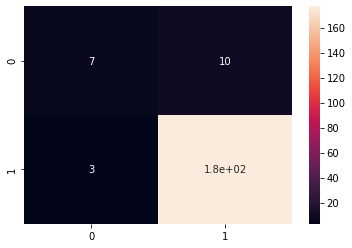

In [56]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True);

In [57]:
y_test.value_counts()

1    180
0     17
Name: last.status, dtype: int64

### Insight: There is a class imbalance in the target. The test size will be increased, and will use various resampling techniques to address the imbalance (SMOTE, etc). We can also use XGBoost as another algorithm to for classification.

**Can GridSearchCV improve modeling scores??**

In [58]:
param_grid = {'penalty':['l2', 'l1','elasticnet'],
             'max_iter':[1000, 10000, 100000]}

Grid = GridSearchCV(estimator=lr, param_grid=param_grid)
Grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'max_iter': [1000, 10000, 100000],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [59]:
Grid.best_params_

{'max_iter': 100000, 'penalty': 'l2'}

#### GridSearchCV concludes that initial conditions were best. Will use Cross validation to determine model performance

In [60]:
print(cross_val_score(lr, X_train, y_train, cv=5).mean())
print(cross_val_score(lr, X_test, y_test, cv=5).mean())

0.9355060858424087
0.8326923076923076


**Insight: the model is overfit. This verifies the data must be resampled. SMOTE and adjusting test size will be done**

In [61]:
# will increasing the test size improve the model and help overfitting?

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.30, random_state=42)

lr2 = LogisticRegression(random_state=42, max_iter=10000)
lr2.fit(X_train2, y_train2)
y_pred2 = lr2.predict(X_test2)
lr2.score(X_test2, y_test2)

0.9213197969543148

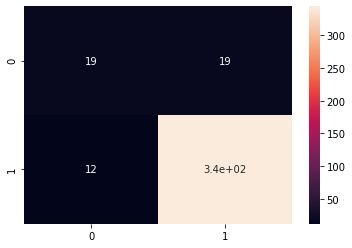

In [62]:
cf_matrix2 = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cf_matrix2, annot=True);

In [63]:
print(cross_val_score(lr2, X_train2, y_train2, cv=5).mean())
print(cross_val_score(lr2, X_test2, y_test2, cv=5).mean())

0.9379959610358755
0.8934761441090556


In [64]:
y_test2.value_counts()

1    356
0     38
Name: last.status, dtype: int64

### Insight: increasing the test size improves model performance, but still 

In [65]:
#KNN attempt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train2)
y_pred_knn = knn.predict(X_test2)
knn.score(X_test, y_test)

0.9137055837563451

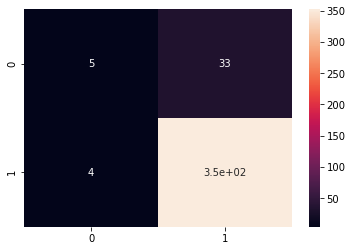

In [66]:
knn_matrix = confusion_matrix(y_test2, y_pred_knn)
sns.heatmap(knn_matrix, annot=True);

In [67]:
knn_params = {'n_neighbors':[3, 5, 7, 9, 11], 'metric': ['euclidian', 'manhattan', 'minkowski']}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params)
knn_grid.fit(X_train2, y_train2)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11]})

In [68]:
knn_grid.best_params_

{'metric': 'minkowski', 'n_neighbors': 9}

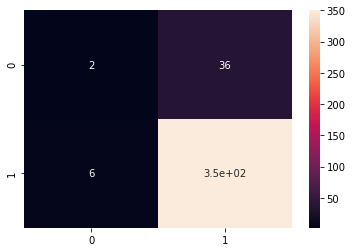

In [69]:
knn2 = KNeighborsClassifier(n_neighbors=9)

knn2.fit(X_train2, y_train2)
knn_pred2 = knn2.predict(X_test2)
knn_matrix2 = confusion_matrix(y_test2, knn_pred2)
sns.heatmap(knn_matrix2, annot=True);

In [74]:
def metrics_crossval_score(model, X_train, X_test, y_train, y_test, y_pred):
    train = cross_val_score(model, X_train, y_train, cv=5).mean()
    test = cross_val_score(model, X_test, y_test, cv=5).mean()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    return ("Training set score:", train), ("Test set score:", test), ('Accuracy:', acc), ('F1 score:', f1), ('Precision:', prec)

metrics_crossval_score(knn2, X_train2, X_test2, y_train2, y_test2, knn_pred2)

(('Training set score:', 0.8933772867664528),
 ('Test set score:', 0.8985069782538136),
 ('Accuracy:', 0.8934010152284264),
 ('F1 score:', 0.9433962264150944),
 ('Precision:', 0.9067357512953368))

In [75]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return sns.heatmap(matrix, annot=True)

### Insight: while this model doesn't predict well, it is well fit to the data for both train and test. can we optimize further?

<AxesSubplot:>

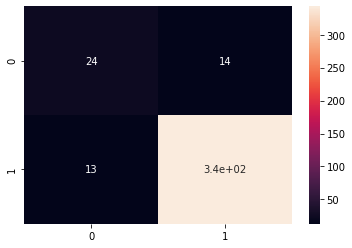

In [77]:
#XGBoost attempt and plot confusion matrix

from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(X_train2, y_train2)
gbc_pred = GBC.predict(X_test2)
plot_matrix(y_test2, gbc_pred)

In [78]:
#crossval score and metrics for GB model
metrics_crossval_score(GBC, X_train2, X_test2, y_train2, y_test2, gbc_pred)

(('Training set score:', 0.9259978617248754),
 ('Test set score:', 0.8909120415449528),
 ('Accuracy:', 0.9314720812182741),
 ('F1 score:', 0.9621318373071528),
 ('Precision:', 0.9607843137254902))

### Insight: GB classifier works better than previous models. Can gridsearch optimize further?

In [79]:
gbc_params = {'loss':['deviance', 'exponential'], 'learning_rate':[0.01, 0.1, 0.5, 1.0], 
            'n_estimators':[100, 1000, 5000, 10000]}

gbc_grid = GridSearchCV(estimator=GBC, param_grid=gbc_params)
gbc_grid.fit(X_train2, y_train2)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [100, 1000, 5000, 10000]})

In [80]:
gbc_grid.best_params_

{'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 100}

<AxesSubplot:>

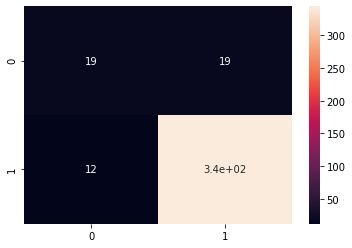

In [81]:
GBC2 = GradientBoostingClassifier(loss='exponential', learning_rate=1.0, n_estimators=100)
GBC2.fit(X_train2, y_train2)
gbc2_pred = GBC2.predict(X_test2)
plot_matrix(y_test2, gbc2_pred)

In [82]:
metrics_crossval_score(GBC2, X_train2, X_test2, y_train2, y_test2, gbc2_pred)

(('Training set score:', 0.9303575671180802),
 ('Test set score:', 0.8883479389808503),
 ('Accuracy:', 0.9213197969543148),
 ('F1 score:', 0.9568845618915162),
 ('Precision:', 0.9476584022038568))